In [1]:
import os
os.chdir(r'C:\Users\tamas\Documents\GitHub\deeplearning\model_functions')
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from model import SimpleLSTM, SpacedLSTM
from lstm_functions import quantile_loss, predict_model, plot_forecasts
from data_prep import prepare_data
os.chdir(r'C:\Users\tamas\Documents\GitHub\deeplearning\formatted_data')


In [2]:
file_path = 'formatted_data.csv'
dense_lookback = 48  # Last 48 hours
spaced_lookback = 365*2*24  # Past 4 weeks (every 24 hours for spaced lookback)
forecast_horizon = 24  # Predict next 24 hours
gas_col = "Price_EUR_MWh"
da_col = "DA"
id_col = "ID"
future_cols = ["Hour_Sin", "Hour_Cos", "Day_Sin", "Day_Cos", "Month_Sin", "Month_Cos"]
quantiles = [0.2, 0.5, 0.8]

# Prepare datasets
train_dense_past, train_future, train_targets, val_dense_past, val_future, val_targets, test_dense_past, test_future, test_targets, target_scaler = prepare_data(
    file_path=file_path,
    dense_lookback=dense_lookback,
    spaced_lookback=0,  # No spaced lookback
    forecast_horizon=forecast_horizon,
    future_cols=future_cols,
    gas_col=gas_col,
    da_col=da_col,
    id_col=id_col,
    spaced=False
)

# Create DataLoaders
train_loader = DataLoader(
    TensorDataset(train_dense_past, train_future, train_targets),
    batch_size=64,
    shuffle=True,
)
val_loader = DataLoader(
    TensorDataset(val_dense_past, val_future, val_targets),
    batch_size=64,
    shuffle=False,
)
test_loader = DataLoader(
    TensorDataset(test_dense_past, test_future, test_targets),
    batch_size=1,
    shuffle=False,
)

In [3]:
# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = SimpleLSTM(
    past_input_size=train_dense_past.shape[2],
    future_input_size=len(future_cols),
    hidden_size=128,
    num_layers=2,
    dropout=0.2,
    past_horizons=train_dense_past.shape[1],
    forecast_horizon=forecast_horizon,
    quantiles=quantiles,
).to(device)

optimizer1 = torch.optim.AdamW(model1.parameters(), lr=0.0005, weight_decay=1e-4)

In [4]:
def plot_training_validation_loss(train_losses, val_losses):
    """
    Plots training and validation losses.
    """
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [5]:
# Training and Validation Function for Forked Training
def train_and_val(train_loader, val_loader, num_epochs, model, optimizer, quantiles, device):
    """
    Trains and validates the model using both past and future data simultaneously.
    """
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        train_loss = 0
        for batch_idx, (past_inputs, future_inputs, targets) in enumerate(train_loader):
            past_inputs, future_inputs, targets = (
                past_inputs.to(device).float(),
                future_inputs.to(device).float(),
                targets.to(device).float(),
            )

            optimizer.zero_grad()
            forecasts = model(past_inputs, future_inputs)
            loss = quantile_loss(targets, forecasts, quantiles)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= (batch_idx + 1)
        train_losses.append(train_loss)

        # Validation Phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_idx, (past_inputs, future_inputs, targets) in enumerate(val_loader):
                past_inputs, future_inputs, targets = (
                    past_inputs.to(device).float(),
                    future_inputs.to(device).float(),
                    targets.to(device).float(),
                )

                forecasts = model(past_inputs, future_inputs)
                loss = quantile_loss(targets, forecasts, quantiles)
                val_loss += loss.item()

        val_loss /= (batch_idx + 1)
        val_losses.append(val_loss)

        print(
            f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}"
        )

    # Plot Training and Validation Losses
    plot_training_validation_loss(train_losses, val_losses)
    return model, train_losses, val_losses

Epoch [1/15], Training Loss: 0.1228, Validation Loss: 0.0530
Epoch [2/15], Training Loss: 0.0589, Validation Loss: 0.0508
Epoch [3/15], Training Loss: 0.0548, Validation Loss: 0.0662
Epoch [4/15], Training Loss: 0.0499, Validation Loss: 0.0609
Epoch [5/15], Training Loss: 0.0475, Validation Loss: 0.0632
Epoch [6/15], Training Loss: 0.0458, Validation Loss: 0.0552
Epoch [7/15], Training Loss: 0.0425, Validation Loss: 0.0572
Epoch [8/15], Training Loss: 0.0400, Validation Loss: 0.0543
Epoch [9/15], Training Loss: 0.0384, Validation Loss: 0.0455
Epoch [10/15], Training Loss: 0.0377, Validation Loss: 0.0478
Epoch [11/15], Training Loss: 0.0361, Validation Loss: 0.0484
Epoch [12/15], Training Loss: 0.0358, Validation Loss: 0.0480
Epoch [13/15], Training Loss: 0.0352, Validation Loss: 0.0449
Epoch [14/15], Training Loss: 0.0337, Validation Loss: 0.0444
Epoch [15/15], Training Loss: 0.0328, Validation Loss: 0.0441


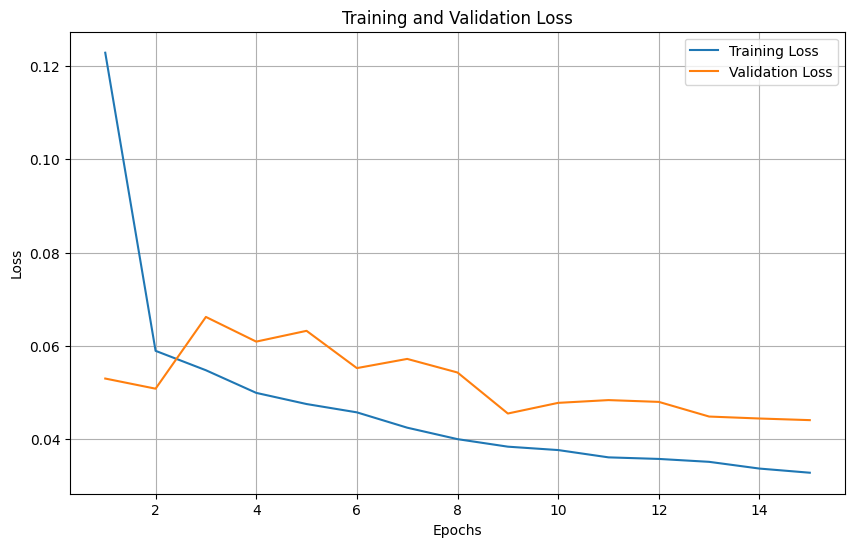

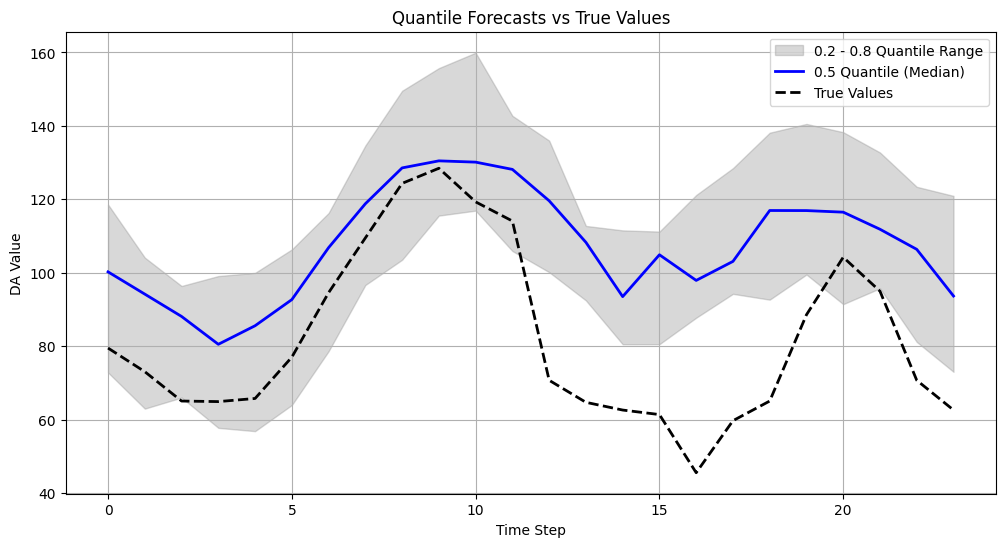

In [6]:
# Train model
simple_model, train_losses, val_losses = train_and_val(
    train_loader, val_loader, num_epochs=15, model=model1, optimizer=optimizer1, quantiles=quantiles, device=device
)
# # Predict
forecast_inv, true_inv = predict_model(simple_model, test_loader, target_scaler, quantiles=quantiles, forecast_horizon=24, device=device)

# # Plot results
plot_forecasts(forecast_inv, true_inv, sample_idx=0, quantiles=quantiles, forecast_horizon=24)

In [7]:
# Parameters
file_path = 'formatted_data.csv'
dense_lookback = 48  # Last 48 hours
spaced_lookback = 100 * 24  # Past 2 years spaced lookback with dynamic steps
forecast_horizon = 24  # Predict next 24 hours
gas_col = "Price_EUR_MWh"
da_col = "DA"
id_col = "ID"
future_cols = ["Hour_Sin", "Hour_Cos", "Day_Sin", "Day_Cos", "Month_Sin", "Month_Cos"]
quantiles = [0.2, 0.5, 0.8]

# Prepare datasets with dense and spaced inputs
(
    train_dense_past,
    train_spaced_past,
    train_future,
    train_targets,
    val_dense_past,
    val_spaced_past,
    val_future,
    val_targets,
    test_dense_past,
    test_spaced_past,
    test_future,
    test_targets,
    target_scaler,
) = prepare_data(
    file_path=file_path,
    dense_lookback=dense_lookback,
    spaced_lookback=spaced_lookback,
    forecast_horizon=forecast_horizon,
    future_cols=future_cols,
    gas_col=gas_col,
    da_col=da_col,
    id_col=id_col,
    spaced=True,
    step_growth_factor=2,
)

# Create DataLoaders
train_loader = DataLoader(
    list(zip(train_dense_past, train_spaced_past, train_future, train_targets)),
    batch_size=64,
    shuffle=True,
)
val_loader = DataLoader(
    list(zip(val_dense_past, val_spaced_past, val_future, val_targets)),
    batch_size=64,
    shuffle=False,
)
test_loader = DataLoader(
    list(zip(test_dense_past, test_spaced_past, test_future, test_targets)),
    batch_size=1,
    shuffle=False,
)



In [8]:
# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = SpacedLSTM(
    dense_input_size=train_dense_past.shape[2],
    spaced_input_size=train_spaced_past.shape[2],
    future_input_size=len(future_cols),
    hidden_size=128,
    num_layers=2,
    dropout=0.2,
    dense_horizons=dense_lookback,
    spaced_horizons=train_spaced_past.shape[1],
    forecast_horizon=forecast_horizon,
    quantiles=quantiles,
).to(device)

# Optimizer
optimizer2 = torch.optim.AdamW(model2.parameters(), lr=0.0005, weight_decay=1e-4)

In [9]:
def train_and_val(train_loader, val_loader, num_epochs, model, optimizer, quantiles, device):
    """
    Train and validate the SpacedLSTM model using dense, spaced, and future data.
    
    Args:
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        num_epochs (int): Number of epochs for training.
        model (nn.Module): The SpacedLSTM model to train.
        optimizer (torch.optim.Optimizer): Optimizer for model training.
        quantiles (list): List of quantiles for loss calculation.
        device (torch.device): Device to run training on ('cpu' or 'cuda').
    
    Returns:
        model (nn.Module): The trained model.
        train_losses (list): List of average training losses per epoch.
        val_losses (list): List of average validation losses per epoch.
    """
    train_losses, val_losses = [], []

    for epoch in range(1, num_epochs + 1):
        # Training Phase
        model.train()
        epoch_train_loss = 0
        for batch_idx, (dense_inputs, spaced_inputs, future_inputs, targets) in enumerate(train_loader):
            # Move data to the specified device
            dense_inputs, spaced_inputs, future_inputs, targets = (
                dense_inputs.to(device).float(),
                spaced_inputs.to(device).float(),
                future_inputs.to(device).float(),
                targets.to(device).float(),
            )

            # Forward pass
            optimizer.zero_grad()
            forecasts = model(dense_inputs, spaced_inputs, future_inputs)

            # Calculate loss
            loss = quantile_loss(targets, forecasts, quantiles)

            # Backpropagation and optimization
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        # Average training loss for the epoch
        epoch_train_loss /= len(train_loader)
        train_losses.append(epoch_train_loss)

        # Validation Phase
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for batch_idx, (dense_inputs, spaced_inputs, future_inputs, targets) in enumerate(val_loader):
                # Move data to the specified device
                dense_inputs, spaced_inputs, future_inputs, targets = (
                    dense_inputs.to(device).float(),
                    spaced_inputs.to(device).float(),
                    future_inputs.to(device).float(),
                    targets.to(device).float(),
                )

                # Forward pass
                forecasts = model(dense_inputs, spaced_inputs, future_inputs)

                # Calculate loss
                loss = quantile_loss(targets, forecasts, quantiles)
                epoch_val_loss += loss.item()

        # Average validation loss for the epoch
        epoch_val_loss /= len(val_loader)
        val_losses.append(epoch_val_loss)

        # Log epoch results
        print(
            f"Epoch [{epoch}/{num_epochs}], Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}"
        )

    # Plot Training and Validation Losses
    plot_training_validation_loss(train_losses, val_losses)

    return model, train_losses, val_losses

Epoch [1/15], Training Loss: 0.0296, Validation Loss: 0.0447
Epoch [2/15], Training Loss: 0.0292, Validation Loss: 0.0435
Epoch [3/15], Training Loss: 0.0284, Validation Loss: 0.0422
Epoch [4/15], Training Loss: 0.0276, Validation Loss: 0.0443
Epoch [5/15], Training Loss: 0.0273, Validation Loss: 0.0429
Epoch [6/15], Training Loss: 0.0268, Validation Loss: 0.0449
Epoch [7/15], Training Loss: 0.0263, Validation Loss: 0.0463
Epoch [8/15], Training Loss: 0.0264, Validation Loss: 0.0433
Epoch [9/15], Training Loss: 0.0260, Validation Loss: 0.0456
Epoch [10/15], Training Loss: 0.0263, Validation Loss: 0.0452
Epoch [11/15], Training Loss: 0.0258, Validation Loss: 0.0458
Epoch [12/15], Training Loss: 0.0253, Validation Loss: 0.0454
Epoch [13/15], Training Loss: 0.0251, Validation Loss: 0.0464
Epoch [14/15], Training Loss: 0.0247, Validation Loss: 0.0427
Epoch [15/15], Training Loss: 0.0247, Validation Loss: 0.0441


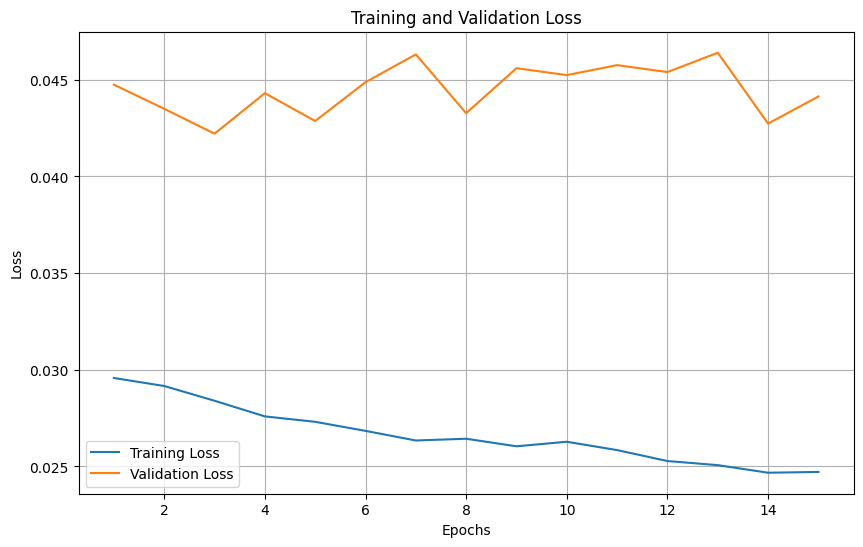

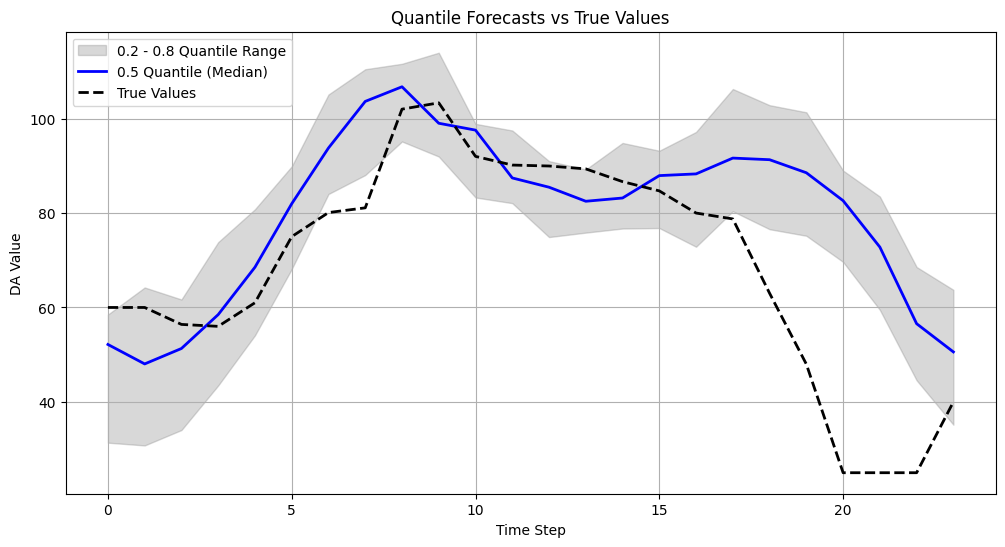

In [11]:
# Train model
spaced_model, train_losses, val_losses = train_and_val(
    train_loader, val_loader, num_epochs=15, model=model2, optimizer=optimizer2, quantiles=quantiles, device=device
)
# # Predict
forecast_inv, true_inv = predict_model(spaced_model, test_loader, target_scaler, quantiles=quantiles, forecast_horizon=24, device=device, spaced=True)

# # Plot results
plot_forecasts(forecast_inv, true_inv, sample_idx=0, quantiles=quantiles, forecast_horizon=24)